<h2>Predict Employee Churn with Decision Trees and Random Forests</h2>

### Importing Libraries

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Exploratory Data Analysis

In [4]:
hr = pd.read_csv('employee_data.csv')
hr_orig = hr
hr.head()

satisfaction_level  last_evaluation  ...  department  salary
0                0.38             0.53  ...       sales     low
1                0.80             0.86  ...       sales  medium
2                0.11             0.88  ...       sales  medium
3                0.72             0.87  ...       sales     low
4                0.37             0.52  ...       sales     low

[5 rows x 10 columns]

### Encode Categorical Features

In [11]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

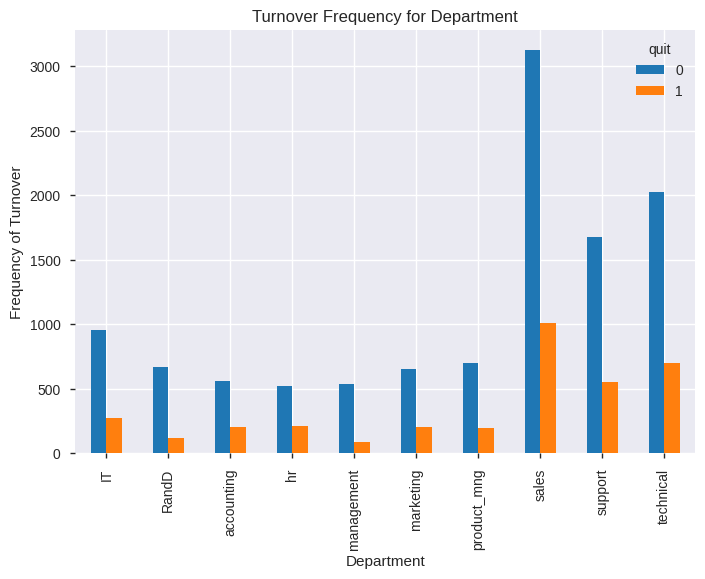

In [12]:
pd.crosstab(hr.department,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

In [13]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1

In [14]:
hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'quit',
       'promotion_last_5years', 'department', 'salary', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype='object')

In [15]:
hr.drop(columns=['department','salary'], axis=1, inplace=True)

### Data Visualization

In [16]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

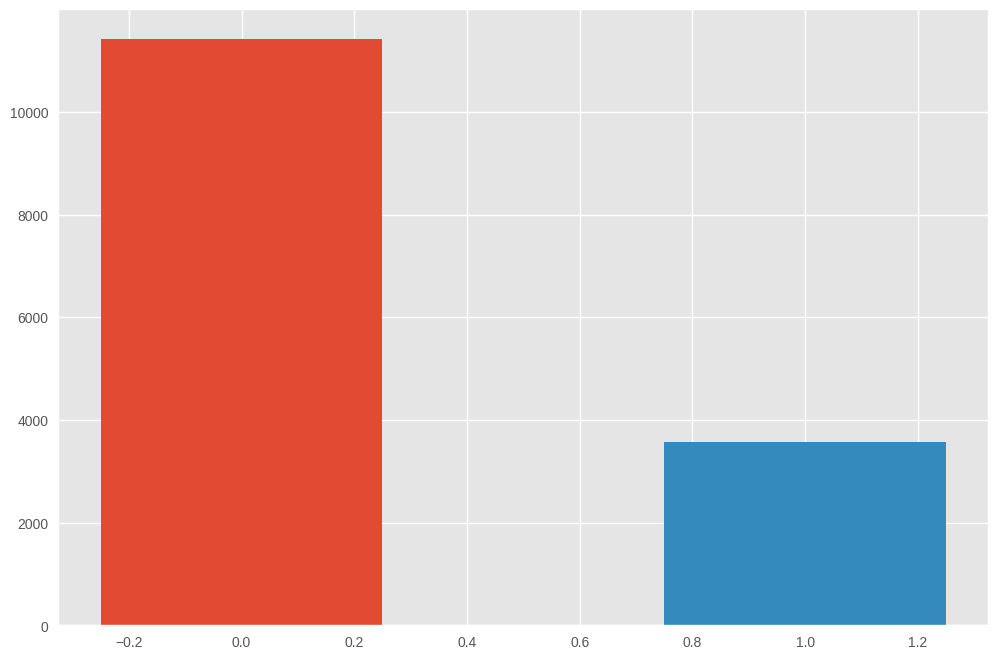

In [19]:
visualizer = ClassBalance(labels=["stayed", "quit"])

visualizer.fit(hr.quit);

### Build an Interactive Decision Tree Classifier

In [20]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    stratify=y)

In [22]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    graph = Source(tree.export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Build an Interactive Random Forest Classifier

In [23]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(X_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Decision Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature Importance and Evaluation Metrics

In [33]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

In [34]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

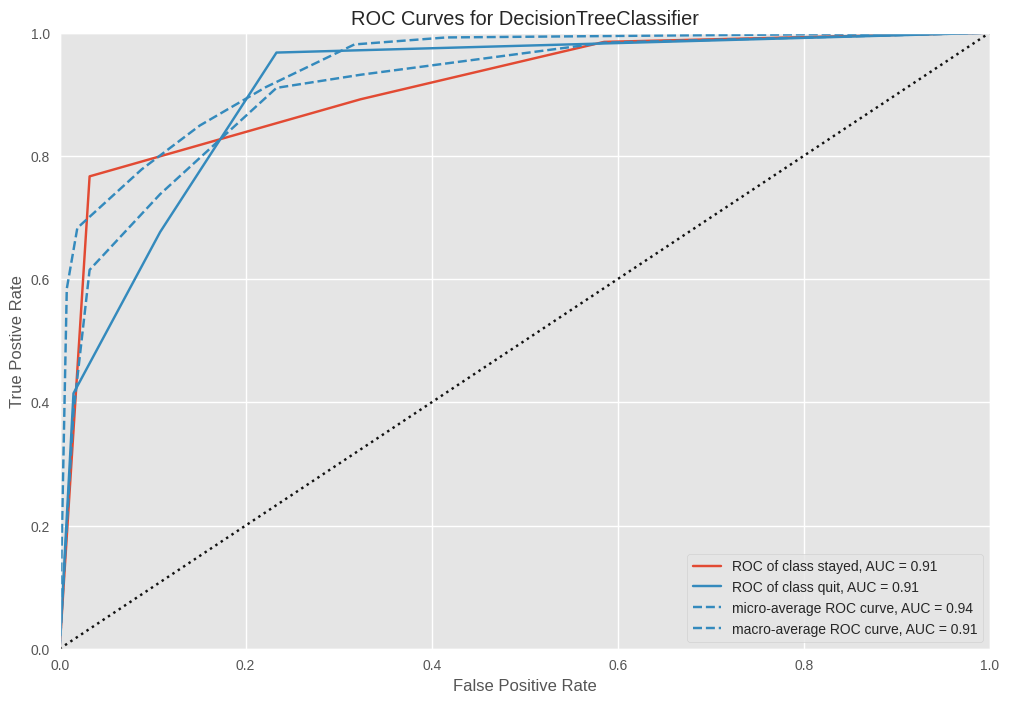

In [29]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

### Comparison with Logistic Regression Classifier

Logistic Regression Accuracy: 0.791


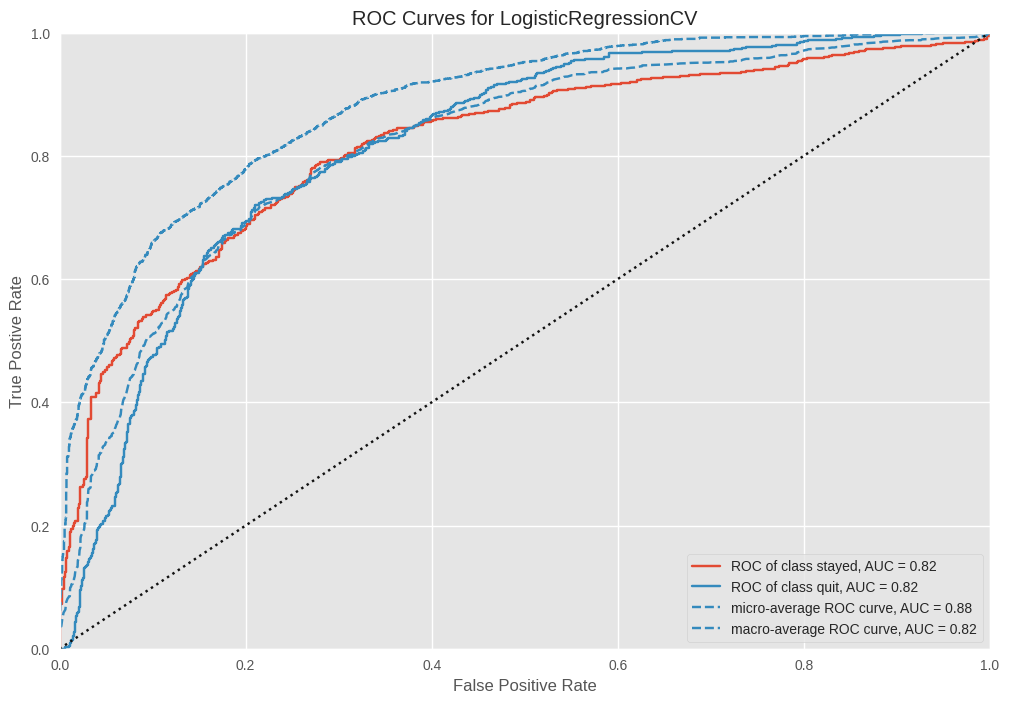

In [30]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();